In [155]:
%reset

In [156]:
import torch.utils.data as data
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import torch
import abc
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from typing import List

#### Set up criteria for classifying the data

In [157]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

In [158]:
COLUMNS_TO_DUMMY = [
    "HeatingType",
    "AptManageType",
    "HallwayType",
    "TimeToBusStop",
    "TimeToSubway",
    "SubwayStation",
]
OUTPUT_COLUMN = "SalePrice"

# Create a dataset class for classification

In [159]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self._prepare_data()
        self.headers = list(self.data.columns)
        self._to_tensor()
        self.size = self.data.shape[0]

    def __len__(self) -> int:
        return self.size

    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns

    def prepare_for_training(self) -> None:
        self.data = self.get_data_as_pandas()
        self._multiply_data()
        self.shuffle()
        self._to_tensor()

    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMNS_TO_DUMMY and column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(
                    self.data[column].values.reshape(-1, 1)
                )

    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMNS_TO_DUMMY)
        if self.scaler:
            self._scale_data()

    def _to_tensor(self) -> None:
        self.headers = list(self.data.columns)
        self.label = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.float32)
        self.data = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]

    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        df = pd.concat([labels, data], axis=1)
        df.columns = self.headers
        return df

    @abc.abstractmethod
    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        return

    def shuffle(self):
        self.data.sample(frac=1)

In [160]:
class HouseDatasetClassification(HouseDataset):
    def __init__(self, path_to_csv: str, scaler=None) -> None:
        super().__init__(path_to_csv, scaler)
        self._classify_data()

    def _classify_data(self) -> None:
        self.label = torch.where(
            self.label > CRITERIUM_MAX_AVERAGE,
            torch.tensor(2),
            torch.where(
                (self.label > CRITERIUM_MAX_CHEAP)
                & (self.label <= CRITERIUM_MAX_AVERAGE),
                torch.tensor(1),
                torch.tensor(0),
            ),
        )

    def _multiply_data(self, number_of_duplicates: int = 1) -> None:
        ros = RandomOverSampler()
        x, y = ros.fit_resample(self.data.iloc[:,1:], self.data[OUTPUT_COLUMN])
        self.data = pd.concat([y, x], axis=1)

In [161]:
path = "../data/train_data.csv"
scaler = MinMaxScaler()

In [162]:
train_dataset_classify = HouseDatasetClassification(path, scaler)
# train_dataset_classify.prepare_for_training()
train_dataset_classify_df = train_dataset_classify.get_data_as_pandas()

In [163]:
# Display the data

In [164]:
train_dataset_classify_df

,SalePrice,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,1,0.756757,0.308356,0.047619,0.155680,0.139288,0.153846,0.000000,0.444444,0.3750,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0.189189,0.205268,0.166667,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0.189189,0.205268,0.119048,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,0.756757,0.872389,0.166667,0.349229,0.405753,0.307692,0.407407,0.444444,0.1875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0.378378,0.231154,0.023810,0.199158,0.059803,0.230769,0.296296,0.222222,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2,0.783784,0.814260,0.547619,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4120,1,1.000000,0.231154,0.500000,0.143058,0.302801,0.307692,0.370370,0.666667,0.4375,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4121,2,0.783784,0.332879,0.452381,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4122,1,0.000000,0.541326,0.000000,0.122020,0.000000,0.000000,0.148148,0.222222,0.4375,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [165]:
train_dataset_classify_df.iloc[:, 0].value_counts()

SalePrice
1    2992
2     570
0     562
Name: count, dtype: int64

# Classification model

In [166]:
class HousingClassificationModel(nn.Module):
    def __init__(self, input_size: int, class_num: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 56)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.LeakyReLU()
        self.fc2 = nn.Linear(56, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32,  class_num)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        # x = self.bn2(x)
        x = self.fc3(x)
        return x

####  Prepare loaders and set batch size

In [167]:
batch_size = 32
train_loader_classify = data.DataLoader(train_dataset_classify, batch_size=batch_size, shuffle=True)
validation_loader_classify = data.DataLoader(train_dataset_classify, batch_size=batch_size, shuffle=True)

#### Split the data into training and validation

In [168]:
X_train_classify, X_test_classify, y_train_classify, y_test_classify = train_test_split(
    train_dataset_classify.data, train_dataset_classify.label, test_size=0.33, random_state=42
)
train_data_classify = data.TensorDataset(X_train_classify, y_train_classify)
validation_data_classify = data.TensorDataset(X_test_classify, y_test_classify)

#### Set up the model, optimizer and loss function

In [169]:
model_classify = HousingClassificationModel(input_size=train_dataset_classify.data.shape[1], class_num=3)
optimizer = torch.optim.Adam(model_classify.parameters(), lr=0.001)
loss_fn_classify = nn.CrossEntropyLoss(weight=torch.tensor([1.2, 0.9, 1.8]))
mca = MulticlassAccuracy(num_classes=3, average=None)

# Train the model

In [170]:
EPOCHS_NUMBER = 400
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model_classify.train()
    batch_idx = 0
    for data, label in train_loader_classify:
        model_output = model_classify(data).squeeze()
        loss = loss_fn_classify(model_output, label.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        optimizer.zero_grad()
        batch_idx += 1
        train_batch_accuracy_sum += mca(torch.argmax(model_output, dim=1), label)
    mean_error_train = train_batch_loss_sum / len(train_loader_classify)
    train_losses.append(mean_error_train)
    train_batch_accuracy_avg = train_batch_accuracy_sum / batch_idx
    train_accuracies.append(train_batch_accuracy_avg)
    model_classify.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader_classify:
        val_predicts = model_classify(val_inputs).squeeze(dim=1)
        val_loss = loss_fn_classify(val_predicts, val_labels.type(torch.LongTensor))
        val_batch_loss_sum += val_loss.item()
        train_batch_loss = train_batch_loss_sum / (len(train_loader_classify.dataset))
        val_batch_loss = val_batch_loss_sum / (len(validation_loader_classify.dataset))
        val_losses.append(val_batch_loss)
        batch_val_idx = 0
        val_batch_accuracy_sum += mca(torch.argmax(val_predicts, dim=1), val_labels)
    mean_error_val = val_batch_loss_sum / len(train_loader_classify)
    val_batch_accuracy_avg = val_batch_accuracy_sum / batch_idx
    tqdm_progress.set_postfix(
        {
            "Epoch": epoch + 1,
            "Los in train": {mean_error_train},
            "Loss in eval": {mean_error_val},
        }
    )
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)


100%|██████████| 400/400 [00:57<00:00,  6.90it/s, Epoch=400, Los in train={0.288612266035043}, Loss in eval={0.27687909586947096}]  


In [171]:
with torch.no_grad():
    predicts_train = model_classify(X_train_classify.clone().detach())
    predicts_val = model_classify(X_test_classify.clone().detach())
    predicted_argmax_train = torch.argmax(predicts_train, dim=1)
    predicted_argmax_val = torch.argmax(predicts_val, dim=1)

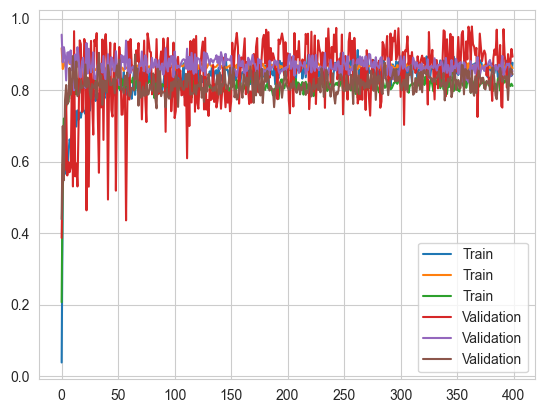

In [172]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [173]:
train_accuracies

[tensor([0.0381, 0.9173, 0.2066]),
 tensor([0.5314, 0.8587, 0.5872]),
 tensor([0.5782, 0.8671, 0.7205]),
 tensor([0.5932, 0.8774, 0.7121]),
 tensor([0.5653, 0.8790, 0.7535]),
 tensor([0.5792, 0.8793, 0.7737]),
 tensor([0.6196, 0.8906, 0.7666]),
 tensor([0.6620, 0.8727, 0.7990]),
 tensor([0.6512, 0.8729, 0.8153]),
 tensor([0.6727, 0.8764, 0.7749]),
 tensor([0.6488, 0.8749, 0.7949]),
 tensor([0.6931, 0.8731, 0.8064]),
 tensor([0.7409, 0.8753, 0.8017]),
 tensor([0.6980, 0.8752, 0.7876]),
 tensor([0.7430, 0.8655, 0.8313]),
 tensor([0.7173, 0.8760, 0.8187]),
 tensor([0.7370, 0.8627, 0.8038]),
 tensor([0.7225, 0.8616, 0.8059]),
 tensor([0.7439, 0.8678, 0.8050]),
 tensor([0.7445, 0.8661, 0.8095]),
 tensor([0.7394, 0.8685, 0.8053]),
 tensor([0.7332, 0.8566, 0.8180]),
 tensor([0.7721, 0.8654, 0.8310]),
 tensor([0.7484, 0.8679, 0.8081]),
 tensor([0.7974, 0.8619, 0.7954]),
 tensor([0.7423, 0.8696, 0.8322]),
 tensor([0.7885, 0.8630, 0.8213]),
 tensor([0.8069, 0.8497, 0.8081]),
 tensor([0.7864, 0.8

In [174]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

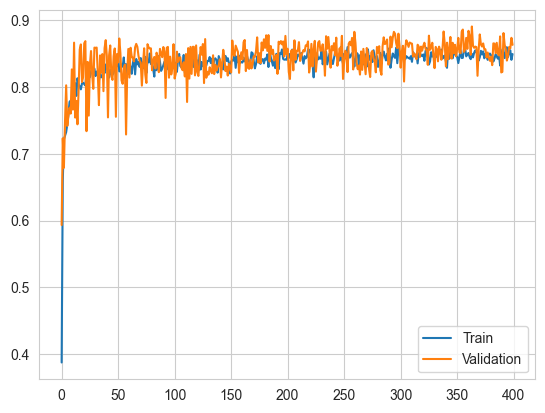

In [175]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()

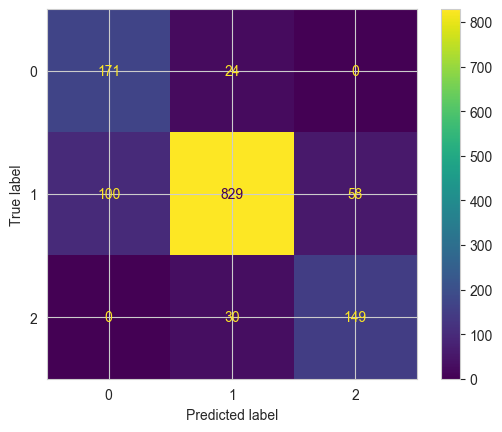

In [176]:
conf_matrix_val = confusion_matrix(y_test_classify, predicted_argmax_val)
ConfusionMatrixDisplay(conf_matrix_val).plot()
plt.show()

In [177]:
f1_score(y_test_classify, predicted_argmax_val, average="micro")

0.8442321822189567